# `Практикум по программированию на языке Python`

## `Задание 03. Рекуррентные Нейронные Сети. Dropout. LM`

#### Фамилия, имя: Кривуля Полина

Дата выдачи: <span style="color:red">__03 апреля 04:00__</span>.

Мягкий дедлайн: <span style="color:red">__18 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __7 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2023`

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# `Часть 0. Загрузка и предобработка данных (1 балл)`

## `Рекомендуемые гиперпараметры`

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать — скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [3]:
# YOUR CODE HERE
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-20 19:11:04--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.8MB/s    in 8.3s    

2023-04-20 19:11:13 (9.70 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [4]:
# YOUR CODE HERE
!tar -xvzf aclImdb_v1.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclI

Посмотрите в файле `./aclImdb/README` как организованы данные:

In [5]:
! cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [6]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [7]:
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти — размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [9]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`, ...)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [10]:
import re

In [11]:
def tokenize(text):
    """
    :param str text: Input text 
    :return List[str]: List of words
    """
    # YOUR CODE HERE
    res = text.lower()  # Привести текст к нижнему регистру
    res = re.sub(r"<br />", " ", res)  # Убрать html разметку из текстов 
    res = re.sub('[^a-z]+', " ", res)  # Убрать все символы кроме латинских букв
    res = res.split()  
    res = [word for word in res if word not in STOPWORDS]
    return res

In [12]:
tokenize('1. Hello <br /> words!! <br />')

['hello', 'words']

Теперь мы можем создать словарь, с помощью которого мы будем численно кодировать токены из текста и наоборот.

Удобной обёрткой для создания словарей является класс `torchtext.vocab.Vocab` и фабрика для создания таких классов `torchtext.vocab.vocab`.

In [13]:
torchtext.vocab.vocab??

Чтобы создать такой словарь, сначала нужно создать словарь со всеми токенами в тексте и их частотами встречаемости:

In [14]:
counter = defaultdict(int)

for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
    for file_path in os.listdir(path):
        text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
        for token in tokenize(text):
            counter[token] += 1

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре

In [15]:
specials = ['<pad>', '<unk>']
for special in specials:
    counter[special] = 0

Создайте словарь из словаря частот `counter`. Наименьшие *id* отдайте под специальные токены. 

Отбросьте низкочастотные слова, оставив только `top_n_words` слов. Можете использовать любой способ реализации этого условия, например:
1. Оставить в словаре `counter` нужное число слов
2. Подобрать параметр `min_freq`, чтобы оставшееся число слов было близко к необходимому порогу

In [16]:
counter['<pad>']

0

In [17]:
# YOUR CODE HERE
# from torchtext.vocab import vocab
from collections import OrderedDict
vocab = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:top_n_words]
vocab = torchtext.vocab.vocab(OrderedDict(vocab))

In [18]:
len(vocab)

5000

In [19]:
vocab.insert_token(specials[0], 0)
vocab.insert_token(specials[1], 1)

In [20]:
vocab.set_default_index(vocab['<unk>'])

In [21]:
vocab.lookup_indices(['<pad>', '<unk>'])

[0, 1]

In [22]:
vocab.lookup_indices(['this', 'film', 'was', 'awful'])

[1, 3, 1, 254]

Теперь мы готовы создать обёртку-датасет для наших данных. 

Необходимо добавить несколько опции, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. Обратите особое внимание, что у длинных текстов не должен обрезаться паддинг
2. В исходных данных рейтинг закодирован в названии файла в виде числа от $1$ до $10$. Для удобства, вычтите $1$, чтобы рейтинг был от $0$ до $9$

In [23]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, vocab, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param torchtext.vocab.Vocab vocab: dictionary with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos> 
        :param bool pad_eos: If True pad sequence at the end with <eos>         
        """
        super().__init__()
        
        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')
        
        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))
        
        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)
        
        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in self.negative_paths + self.positive_paths:
            # YOUR CODE HERE
            file = open(path, 'r')
            self.texts.append(file.read())
            self.tokens.append(vocab.lookup_indices(tokenize(self.texts[-1]))[:max_len])
            # рейтинг перед .txt
            r = int(path[-5])
            if r == 0:
                r = 10
            self.ratings.append(r - 1)
        
    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data 
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
        # YOUR CODE HERE
        # Do not forget to add padding if needed!
        
        d = dict()
        d['text'] = self.texts[idx]
        d['label'] = torch.tensor([self.labels[idx]], dtype=torch.long)
        d['rating'] = torch.tensor(self.ratings[idx], dtype=torch.long)
        
        tokens = []
        minus_len = 0
        if self.pad_sos:
            tokens = [self.sos_id]
            minus_len += 1
        tokens += self.tokens[idx]
        if self.pad_eos:
            tokens += [self.eos_id]
            minus_len += 1
        
        d['tokens'] = torch.tensor(tokens, dtype=torch.long)
        d['tokens_len'] = torch.tensor(len(tokens) - minus_len, dtype=torch.long)
        return d
    
    def __len__(self):
        """
        :return int: number of objects in dataset 
        """
        # YOUR CODE HERE
        return len(self.texts)

Создайте датасеты для тестовой и обучающей выборки. 

Обратите внимание, что для задачи классификации нам не потребуется паддинг с помощью `<sos>`, `<eos>`. 

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [24]:
# YOUR CODE HERE
test_dataset = LargeMovieReviewDataset(test_data_path, vocab, max_length)
train_dataset = LargeMovieReviewDataset(train_data_path, vocab, max_length)

Посмотрим, как выглядит объект в датасете:

In [25]:
test_dataset[0]

{'text': "First of all, Ed Wood Jr. is not the worst director ever, Plan 9 From Outer Space not withstanding. Coleman Francis deserves that title. I present Exhibit B, Glen or Glenda.<br /><br />The first half of the movie consists of a surprisingly thoughtful exploration of crossdressing, especially since it was made in 1953. The last 15 minutes of movie are also not bad as well.<br /><br />This is not to say the movie doesn't have problems. Bela Lugosi was totally extraneous, intoning odd lines. Poor Bela looked like even he wasn't sure what was happening at times. The acting was decidely wooden, though no worse than a period Universal B movie. The long dream sequence that makes up the middle of the film was totally bizarre; more like a vaguely menacing stag film than a dream sequence. The Alan/Ann story, the supposed original focus of the film has a tacked on quality about it.<br /><br />No, Ed Wood Jr. is not the worst director ever. He was able, at least for part of this movie, to

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем 
2. `padding_value` — число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины

In [26]:
torch.nn.utils.rnn.pad_sequence([
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
], batch_first=False, padding_value=-1)

tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])

In [27]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.Tensor(dtype=torch.long): sentiment of the text for each object in batch
            
            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    # YOUR CODE HERE
    d = dict()
    ratings, labels, texts, tokens, tokens_lens = [], [], [], [], []
    for x in batch:
        ratings.append(x['rating'])
        labels.append(x['label'])
        texts.append(x['text'])
        tokens.append(x['tokens'])
        tokens_lens.append(x['tokens_len'])
    d['ratings'] = torch.tensor(ratings, dtype=torch.long)
    d['labels'] = torch.tensor(labels, dtype=torch.long)
    d['texts'] = texts
    d['tokens'] = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=batch_first, 
                                                  padding_value=padding_value)
    d['tokens_lens'] = torch.tensor(tokens_lens, dtype=torch.long)
    
    return d

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.

In [28]:
# YOUR CODE HERE
from functools import partial

part = partial(collate_fn, padding_value=vocab.lookup_indices(['<pad>'])[0])

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                             shuffle=False, collate_fn=part, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, collate_fn=part, num_workers=0)

Посмотрим на какой-нибудь батч:

In [29]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([3, 2, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 1, 1, 0, 3, 1, 2, 3, 3, 2,
         0, 0, 2, 1, 2, 0, 3, 0, 3, 3, 1, 2, 0, 2, 1, 0, 0, 1, 0, 0, 3, 3, 0, 0,
         3, 2, 3, 3, 0, 0, 2, 1, 3, 0, 3, 1, 2, 0, 2, 1]),
 tensor([[  20,   17, 3642,  ...,    3, 3594,  300],
         [1135, 1041,   71,  ...,   31,    1, 2804],
         [1408,    1, 1530,  ...,  515,  329,   80],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([122,  84,  70, 200,  64,  73, 134,  83, 103,  58,  83,  88,  62,  66,
          73,  31, 179,  68, 152,  44, 106,  61,  79,  43,  63,  43,  81,  8

# `Часть 1. Классификация текстов (4 балла)`

## `Сборка и обучение RNN в pytorch (1 балл)`

Создадим переменные для device-agnostic кода:

In [30]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-эмбеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации. 
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [31]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout
        
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        
        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        # YOUR CODE HERE
        self.word_embeddings = torch.nn.Embedding(num_embeddings=len(vocab), 
                                                  embedding_dim=embedding_dim, 
                                                  padding_idx=vocab.lookup_indices(['<pad>'])[0])

        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        
        # Create linear layer for classification
        # YOUR CODE HERE
        self.output = torch.nn.Linear(in_features=hidden_dim, 
                                      out_features=output_size)
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # tokens размера (N x L)
        # YOUR CODE HERE
        x = self.word_embeddings(tokens)  # size = (N, L, self.embedding_dim)
        
        # Make forward pass through recurrent network
        # YOUR CODE HERE
        x = self.rnn(x)[0]  # size = (N, L, self.hidden_dim)
        
        # Pass output from rnn to linear layer 
        # Note: each object in batch has its own length 
        #     so we must take rnn hidden state after the last token for each text in batch
        # YOUR CODE HERE
        # print(tokens_lens)
        x = x[tokens_lens - 1, torch.arange(len(tokens_lens)), :]
        x = self.output(x)  # size = (L, self.output)
        return x
        

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

In [32]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        # 1
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        ratings = data['ratings'].to(device)
        # 2
        optimizer.zero_grad()
        pred = model(tokens, tokens_lens)
        # 3
        loss = loss_fn(pred, ratings)
        loss.backward()
        # 4
        optimizer.step()
    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            ratings = data['ratings'].to(device)
            
            pred = model(tokens, tokens_lens)
            loss = loss_fn(pred, ratings).item()
            total_loss += loss * len(pred)
            total_accuracy += (torch.max(pred.data, 1)[1] == ratings).sum().cpu() 
            
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Создадим модель:

In [33]:
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, vocab=vocab,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [34]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
import time
start = time.time()

train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_0 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.962/1.964. Accuracy (Train/Test): 0.272/0.275
Epoch: 2/15. Loss (Train/Test): 1.680/1.713. Accuracy (Train/Test): 0.360/0.343
Epoch: 3/15. Loss (Train/Test): 1.595/1.653. Accuracy (Train/Test): 0.381/0.359
Epoch: 4/15. Loss (Train/Test): 1.488/1.580. Accuracy (Train/Test): 0.421/0.382
Epoch: 5/15. Loss (Train/Test): 1.423/1.563. Accuracy (Train/Test): 0.438/0.393
Epoch: 6/15. Loss (Train/Test): 1.384/1.564. Accuracy (Train/Test): 0.462/0.385
Epoch: 7/15. Loss (Train/Test): 1.315/1.550. Accuracy (Train/Test): 0.485/0.391
Epoch: 8/15. Loss (Train/Test): 1.272/1.583. Accuracy (Train/Test): 0.499/0.398
Epoch: 9/15. Loss (Train/Test): 1.208/1.594. Accuracy (Train/Test): 0.526/0.393
Epoch: 10/15. Loss (Train/Test): 1.153/1.635. Accuracy (Train/Test): 0.554/0.376
Epoch: 11/15. Loss (Train/Test): 1.079/1.637. Accuracy (Train/Test): 0.596/0.382
Epoch: 12/15. Loss (Train/Test): 0.988/1.759. Accuracy (Train/Test): 0.618/0.385
Epoch: 13/15. Loss (Train/Test): 0.93

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout (1 балл)`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно). 

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

In [35]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    # YOUR CODE HERE
    h0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    c0 = some_existing_tensor.new_zeros((num_objects, hidden_size))
    return h0, c0

In [36]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)
    
    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    # YOUR CODE HERE
    if p is None:
      h0 = some_existing_tensor.new_ones(hidden_size)
      c0 = some_existing_tensor.new_ones(input_size)
    else:
      if is_training:
        h0 = some_existing_tensor.new_empty(hidden_size).bernoulli_(1 - p)
        c0 = some_existing_tensor.new_empty(input_size).bernoulli_(1 - p)
      else:
        h0 = some_existing_tensor.new_ones(hidden_size) * (1 - p)
        c0 = some_existing_tensor.new_ones(input_size) * (1 - p)
    return c0, h0

Допишите класс-обёртку над `LSTMCell` для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [37]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        h, c = init_h0_c0(x.size(1), self.hidden_size, x)  # (для обоих) size = (x.size(1), self.hidden_size)
        
        # Gen masks for input and hidden state
        # YOUR CODE HERE
        # (self.input_size, 1), (self.hidden_size, 1)
        m_x, m_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
        # (x.size(0), x.size(1), x.size(2))
        x = m_x * x

        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        res = []
        for i in x:
            h, c = self.rnn_cell(i, (h, c))  # (для обоих) size = (x.size(1), self.hidden_size)
            h = m_h * h  # size = (x.size(1), self.hidden_size)
            res.append(h)
        res = torch.stack(res, dim=0)
        return res, (h, c)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
# YOUR CODE HERE
import time
model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=RNNLayer, dropout=None).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_1, train_accuracies_pure_1, test_losses_pure_1, test_accuracies_pure_1 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_1 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.030/2.032. Accuracy (Train/Test): 0.240/0.246
Epoch: 2/15. Loss (Train/Test): 1.830/1.841. Accuracy (Train/Test): 0.322/0.326
Epoch: 3/15. Loss (Train/Test): 1.678/1.715. Accuracy (Train/Test): 0.362/0.347
Epoch: 4/15. Loss (Train/Test): 1.564/1.626. Accuracy (Train/Test): 0.397/0.372
Epoch: 5/15. Loss (Train/Test): 1.493/1.584. Accuracy (Train/Test): 0.416/0.391
Epoch: 6/15. Loss (Train/Test): 1.449/1.570. Accuracy (Train/Test): 0.435/0.388
Epoch: 7/15. Loss (Train/Test): 1.396/1.554. Accuracy (Train/Test): 0.452/0.395
Epoch: 8/15. Loss (Train/Test): 1.360/1.558. Accuracy (Train/Test): 0.470/0.401
Epoch: 9/15. Loss (Train/Test): 1.299/1.570. Accuracy (Train/Test): 0.490/0.402
Epoch: 10/15. Loss (Train/Test): 1.253/1.585. Accuracy (Train/Test): 0.506/0.403
Epoch: 11/15. Loss (Train/Test): 1.197/1.586. Accuracy (Train/Test): 0.539/0.394
Epoch: 12/15. Loss (Train/Test): 1.147/1.638. Accuracy (Train/Test): 0.551/0.397
Epoch: 13/15. Loss (Train/Test): 1.04

In [ ]:
time_0

104.90335702896118

In [ ]:
time_1

686.3973155021667

качество вышло сопоставимым с предыдущей моделью, время увеличилось действительно сильно

Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [ ]:
# YOUR CODE HERE
model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=RNNLayer, dropout=0.25).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_2, train_accuracies_pure_2, test_losses_pure_2, test_accuracies_pure_2 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_2 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.993/1.995. Accuracy (Train/Test): 0.258/0.260
Epoch: 2/15. Loss (Train/Test): 1.841/1.849. Accuracy (Train/Test): 0.319/0.323
Epoch: 3/15. Loss (Train/Test): 1.712/1.731. Accuracy (Train/Test): 0.347/0.350
Epoch: 4/15. Loss (Train/Test): 1.676/1.703. Accuracy (Train/Test): 0.352/0.352
Epoch: 5/15. Loss (Train/Test): 1.604/1.645. Accuracy (Train/Test): 0.372/0.367
Epoch: 6/15. Loss (Train/Test): 1.558/1.612. Accuracy (Train/Test): 0.386/0.374
Epoch: 7/15. Loss (Train/Test): 1.536/1.596. Accuracy (Train/Test): 0.394/0.378
Epoch: 8/15. Loss (Train/Test): 1.516/1.585. Accuracy (Train/Test): 0.407/0.379
Epoch: 9/15. Loss (Train/Test): 1.486/1.574. Accuracy (Train/Test): 0.412/0.384
Epoch: 10/15. Loss (Train/Test): 1.459/1.553. Accuracy (Train/Test): 0.424/0.389
Epoch: 11/15. Loss (Train/Test): 1.440/1.553. Accuracy (Train/Test): 0.436/0.388
Epoch: 12/15. Loss (Train/Test): 1.407/1.535. Accuracy (Train/Test): 0.443/0.397
Epoch: 13/15. Loss (Train/Test): 1.38

In [ ]:
time_2

607.2109274864197

обучается примерно как предыдущая, потому что по сути выполняются те же самые операции

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные по строкам на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Такой слой реализуется в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [38]:
import warnings

In [39]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            # YOUR CODE HERE
            m_x, m_h = gen_dropout_mask(raw_w.size(1), self.hidden_size, self.training, self.dropout, raw_w)
            
            # Apply dropout mask
            # YOUR CODE HERE
            masked_raw_w = raw_w * m_x
            
            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            # YOUR CODE HERE
            self._setweights(x)
            if h_c is None:
                return self.module(x)
            else:
                return self.module(x, h_c)
            
    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
# YOUR CODE HERE

model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=FastRNNLayer, dropout=None).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_3, train_accuracies_pure_3, test_losses_pure_3, test_accuracies_pure_3 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_3 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.008/2.010. Accuracy (Train/Test): 0.241/0.239
Epoch: 2/15. Loss (Train/Test): 1.698/1.723. Accuracy (Train/Test): 0.353/0.348
Epoch: 3/15. Loss (Train/Test): 1.559/1.623. Accuracy (Train/Test): 0.399/0.377
Epoch: 4/15. Loss (Train/Test): 1.491/1.588. Accuracy (Train/Test): 0.416/0.381
Epoch: 5/15. Loss (Train/Test): 1.451/1.576. Accuracy (Train/Test): 0.430/0.392
Epoch: 6/15. Loss (Train/Test): 1.385/1.556. Accuracy (Train/Test): 0.458/0.398
Epoch: 7/15. Loss (Train/Test): 1.320/1.563. Accuracy (Train/Test): 0.480/0.394
Epoch: 8/15. Loss (Train/Test): 1.255/1.571. Accuracy (Train/Test): 0.505/0.394
Epoch: 9/15. Loss (Train/Test): 1.203/1.617. Accuracy (Train/Test): 0.527/0.386
Epoch: 10/15. Loss (Train/Test): 1.150/1.624. Accuracy (Train/Test): 0.556/0.379
Epoch: 11/15. Loss (Train/Test): 1.067/1.696. Accuracy (Train/Test): 0.591/0.375
Epoch: 12/15. Loss (Train/Test): 0.981/1.744. Accuracy (Train/Test): 0.629/0.378
Epoch: 13/15. Loss (Train/Test): 0.90

(убедилась)

Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [ ]:
# YOUR CODE HERE

model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=FastRNNLayer, dropout=0.25).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_4, train_accuracies_pure_4, test_losses_pure_4, test_accuracies_pure_4 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_4 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.994/1.997. Accuracy (Train/Test): 0.246/0.248
Epoch: 2/15. Loss (Train/Test): 1.818/1.834. Accuracy (Train/Test): 0.327/0.325
Epoch: 3/15. Loss (Train/Test): 1.681/1.706. Accuracy (Train/Test): 0.364/0.359
Epoch: 4/15. Loss (Train/Test): 1.614/1.650. Accuracy (Train/Test): 0.380/0.371
Epoch: 5/15. Loss (Train/Test): 1.562/1.620. Accuracy (Train/Test): 0.390/0.362
Epoch: 6/15. Loss (Train/Test): 1.500/1.568. Accuracy (Train/Test): 0.409/0.388
Epoch: 7/15. Loss (Train/Test): 1.467/1.549. Accuracy (Train/Test): 0.424/0.398
Epoch: 8/15. Loss (Train/Test): 1.438/1.537. Accuracy (Train/Test): 0.430/0.400
Epoch: 9/15. Loss (Train/Test): 1.404/1.519. Accuracy (Train/Test): 0.452/0.404
Epoch: 10/15. Loss (Train/Test): 1.392/1.525. Accuracy (Train/Test): 0.447/0.409
Epoch: 11/15. Loss (Train/Test): 1.371/1.527. Accuracy (Train/Test): 0.453/0.410
Epoch: 12/15. Loss (Train/Test): 1.334/1.504. Accuracy (Train/Test): 0.475/0.407
Epoch: 13/15. Loss (Train/Test): 1.32

In [ ]:
time_1

596.3970427513123

In [ ]:
time_2

607.2109274864197

In [ ]:
time_3

109.67784214019775

In [ ]:
time_4

109.53065991401672

(за качеством проследила), время работы уменьшилось в 6 раз

</конец взлома pytorch>

## `Реализация дропаута по статье Семениуты и др. (1 балл)`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165). 

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
На входы $x_t$ маска накладывается как в предыдущем дропауте. Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно: 
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит) 
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала). 

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [40]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)
        
        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch. 
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        # (для обоих) size = (x.size(1), self.hidden_size)
        h, c = init_h0_c0(x.size(1), self.hidden_size, x)   
        # (self.input_size, 1), (self.hidden_size, 1)
        m_x, m_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
        x = m_x * x
        
        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        res = []
        for i in x:
          hz = self.input_weights(i) + self.hidden_weights(h)  # (x.size(1), self.hidden_size * 4)
          # для остальных вроде (x.size(1), self.hidden_size)
          i = torch.sigmoid(hz[:, :self.hidden_size])
          o = torch.sigmoid(hz[:, self.hidden_size : 2 * self.hidden_size])
          f = torch.sigmoid(hz[:, 2 * self.hidden_size : 3 * self.hidden_size])
          g = torch.tanh(hz[:, 3 * self.hidden_size: ])
          c = f * c + i * g * m_h
          h = o * torch.tanh(c)
          res.append(h)
        res = torch.stack(res, dim=0)
        return res, (h, c)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

In [ ]:
# YOUR CODE HERE
model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=HandmadeLSTM, dropout=None).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_5, train_accuracies_pure_5, test_losses_pure_5, test_accuracies_pure_5 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_5 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 1.988/1.989. Accuracy (Train/Test): 0.262/0.266
Epoch: 2/15. Loss (Train/Test): 1.718/1.746. Accuracy (Train/Test): 0.344/0.342
Epoch: 3/15. Loss (Train/Test): 1.573/1.631. Accuracy (Train/Test): 0.396/0.369
Epoch: 4/15. Loss (Train/Test): 1.500/1.589. Accuracy (Train/Test): 0.413/0.382
Epoch: 5/15. Loss (Train/Test): 1.430/1.564. Accuracy (Train/Test): 0.435/0.395
Epoch: 6/15. Loss (Train/Test): 1.363/1.543. Accuracy (Train/Test): 0.460/0.402
Epoch: 7/15. Loss (Train/Test): 1.329/1.540. Accuracy (Train/Test): 0.474/0.402
Epoch: 8/15. Loss (Train/Test): 1.277/1.563. Accuracy (Train/Test): 0.493/0.401
Epoch: 9/15. Loss (Train/Test): 1.211/1.574. Accuracy (Train/Test): 0.526/0.398
Epoch: 10/15. Loss (Train/Test): 1.144/1.641. Accuracy (Train/Test): 0.548/0.385
Epoch: 11/15. Loss (Train/Test): 1.103/1.686. Accuracy (Train/Test): 0.567/0.388
Epoch: 12/15. Loss (Train/Test): 1.021/1.735. Accuracy (Train/Test): 0.607/0.374
Epoch: 13/15. Loss (Train/Test): 0.92

In [ ]:
# YOUR CODE HERE
model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=HandmadeLSTM, dropout=0.25).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_6, train_accuracies_pure_6, test_losses_pure_6, test_accuracies_pure_6 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_6 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.019/2.019. Accuracy (Train/Test): 0.212/0.207
Epoch: 2/15. Loss (Train/Test): 1.854/1.870. Accuracy (Train/Test): 0.316/0.316
Epoch: 3/15. Loss (Train/Test): 1.732/1.759. Accuracy (Train/Test): 0.345/0.344
Epoch: 4/15. Loss (Train/Test): 1.671/1.702. Accuracy (Train/Test): 0.357/0.353
Epoch: 5/15. Loss (Train/Test): 1.604/1.650. Accuracy (Train/Test): 0.375/0.364
Epoch: 6/15. Loss (Train/Test): 1.581/1.643. Accuracy (Train/Test): 0.388/0.373
Epoch: 7/15. Loss (Train/Test): 1.513/1.580. Accuracy (Train/Test): 0.408/0.389
Epoch: 8/15. Loss (Train/Test): 1.504/1.589. Accuracy (Train/Test): 0.414/0.393
Epoch: 9/15. Loss (Train/Test): 1.458/1.552. Accuracy (Train/Test): 0.424/0.398
Epoch: 10/15. Loss (Train/Test): 1.458/1.566. Accuracy (Train/Test): 0.431/0.401
Epoch: 11/15. Loss (Train/Test): 1.432/1.548. Accuracy (Train/Test): 0.431/0.404
Epoch: 12/15. Loss (Train/Test): 1.400/1.531. Accuracy (Train/Test): 0.447/0.406
Epoch: 13/15. Loss (Train/Test): 1.37

In [ ]:
time_5

1773.7459225654602

In [ ]:
time_6

1749.6396505832672

время обучения СИЛЬНО выросло по сравнению со всеми остальными моделями.

## `Сравнение всех предложенных моделей (1 балл)`

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 2m 35s        | 14m 16s  | 2m 41s       | 31m 44s      |

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(columns=['torch.nn.LSTM', 'RNNLayer', 'FastRNNLayer', 'HandmadeLSTM'], index=['without dropout', 'with dropout'])

In [ ]:
import datetime
'''
time = 1000
time = datetime.time(0, time // 60, time % 60)
time
'''

'\ntime = 1000\ntime = datetime.time(0, time // 60, time % 60)\ntime\n'

In [ ]:
time_0

datetime.time(0, 1, 44)

In [ ]:
# torch.nn.LSTM time_0
# RNNLayer time_1, time_2
# FastRNNLayer time_3, time_4
# HandmadeLSTM time_5, time_6
# time_0 = datetime.time(0, int(time_0) // 60, int(time_0) % 60)
time_1 = datetime.time(0, int(time_1) // 60, int(time_1) % 60)
time_2 = datetime.time(0, int(time_2) // 60, int(time_2) % 60)
time_3 = datetime.time(0, int(time_3) // 60, int(time_3) % 60)
time_4 = datetime.time(0, int(time_4) // 60, int(time_4) % 60)
time_5 = datetime.time(0, int(time_5) // 60, int(time_5) % 60)
time_6 = datetime.time(0, int(time_6) // 60, int(time_6) % 60)
df.loc['without dropout'] = [time_0, time_1, time_3, time_5]
df.loc['with dropout'] = [None, time_2, time_4, time_6]

In [ ]:
df

,torch.nn.LSTM,RNNLayer,FastRNNLayer,HandmadeLSTM
without dropout,00:01:44,00:09:56,00:01:49,00:29:33
with dropout,None,00:10:07,00:01:49,00:29:09


Крайне желательно рисовать графики в векторном формате. 

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [ ]:
%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

<ipython-input-65-1d4f17c67935>:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

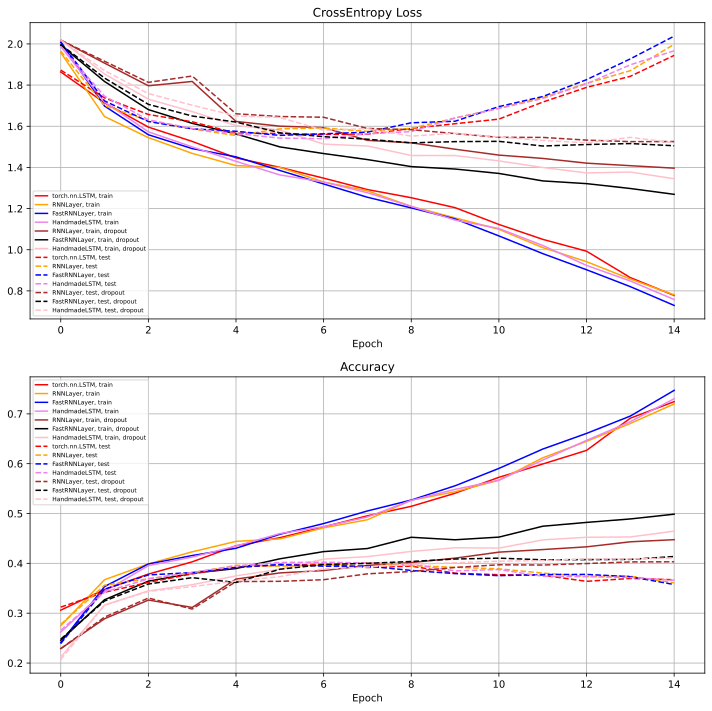

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE

axes[0].plot(train_losses_pure, label='torch.nn.LSTM, train', color='red')
axes[0].plot(train_losses_pure_1, label='RNNLayer, train', color='orange')
axes[0].plot(train_losses_pure_3, label='FastRNNLayer, train', color='blue')
axes[0].plot(train_losses_pure_5, label='HandmadeLSTM, train', color='violet')

axes[0].plot(train_losses_pure_2, label='RNNLayer, train, dropout', color='brown')
axes[0].plot(train_losses_pure_4, label='FastRNNLayer, train, dropout', color='black')
axes[0].plot(train_losses_pure_6, label='HandmadeLSTM, train, dropout', color='pink')

axes[0].plot(test_losses_pure, label='torch.nn.LSTM, test', color='red', linestyle='--')
axes[0].plot(test_losses_pure_1, label='RNNLayer, test', color='orange', linestyle='--')
axes[0].plot(test_losses_pure_3, label='FastRNNLayer, test', color='blue', linestyle='--')
axes[0].plot(test_losses_pure_5, label='HandmadeLSTM, test', color='violet', linestyle='--')

axes[0].plot(test_losses_pure_2, label='RNNLayer, test, dropout', color='brown', linestyle='--')
axes[0].plot(test_losses_pure_4, label='FastRNNLayer, test, dropout', color='black', linestyle='--')
axes[0].plot(test_losses_pure_6, label='HandmadeLSTM, test, dropout', color='pink', linestyle='--')

axes[0].legend(fontsize=6)
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].plot(train_accuracies_pure, label='torch.nn.LSTM, train', color='red')
axes[1].plot(train_accuracies_pure_1, label='RNNLayer, train', color='orange')
axes[1].plot(train_accuracies_pure_3, label='FastRNNLayer, train', color='blue')
axes[1].plot(train_accuracies_pure_5, label='HandmadeLSTM, train', color='violet')

axes[1].plot(train_accuracies_pure_2, label='RNNLayer, train, dropout', color='brown')
axes[1].plot(train_accuracies_pure_4, label='FastRNNLayer, train, dropout', color='black')
axes[1].plot(train_accuracies_pure_6, label='HandmadeLSTM, train, dropout', color='pink')

axes[1].plot(test_accuracies_pure, label='torch.nn.LSTM, test', color='red', linestyle='--')
axes[1].plot(test_accuracies_pure_1, label='RNNLayer, test', color='orange', linestyle='--')
axes[1].plot(test_accuracies_pure_3, label='FastRNNLayer, test', color='blue', linestyle='--')
axes[1].plot(test_accuracies_pure_5, label='HandmadeLSTM, test', color='violet', linestyle='--')

axes[1].plot(test_accuracies_pure_2, label='RNNLayer, test, dropout', color='brown', linestyle='--')
axes[1].plot(test_accuracies_pure_4, label='FastRNNLayer, test, dropout', color='black', linestyle='--')
axes[1].plot(test_accuracies_pure_6, label='HandmadeLSTM, test, dropout', color='pink', linestyle='--')

axes[1].legend(fontsize=6)
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:**
В моделях без Dropout после десятой эпохи качество на тесте значительно ухудшается (сильнее заметно на loss). В моделях с dropout качество (или loss) улучшается на тесте пропорционально трейну. То есть, если на трейне лучше всего себя показывают модели 2, 3, 1 (по степени лучшести), то и на тесте точно также 2, 3, 1. В общем, с использованием dropout лучше всего себя показывает FastRnn (и в плане качества, и в плане loss, и для теста, и для трейна), дальше идет HandmadeLSTM, затем RnnLayer. При этом FastRnn еще и самый быстрый, а вот HandmadeLSTM работает в десятки раз дольше.

## `Бонус. Zoneout (0.5 балла)`

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью $p$ компонента скрытого состояния обновляется, а с вероятностью $1-p$ берется с предыдущего шага. 
В Виде формул ($m^t_h$ - бинарная маска):
 
(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o) 
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad 
g = tanh(h_{t-1} W^g + x_t U^g+b_g) 
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

**Полный балл ставится только при наличии качественного и количественного сравнения с предыдущими моделями.**

In [ ]:
class RNNLayerZoneout(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)
        
    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        h, c = init_h0_c0(x.size(1), self.hidden_size, x)  # (для обоих) size = (x.size(1), self.hidden_size)
        
        # Gen masks for input and hidden state
        # YOUR CODE HERE
        # (self.input_size, 1), (self.hidden_size, 1)
        m_x, m_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
        # (x.size(0), x.size(1), x.size(2))
        x = m_x * x

        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        res = []
        for i in x:
            h_t, c = self.rnn_cell(i, (h, c))
            m_x, m_h = gen_dropout_mask(self.input_size, self.hidden_size, self.training, self.dropout, x)
            h = h_t * m_h + h * (1 - m_h)
            res.append(h)
        res = torch.stack(res, dim=0)
        return res, (h, c)

In [ ]:
# YOUR CODE HERE
# было time_1, time_2 для RNNLayer
model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=RNNLayerZoneout, dropout=None).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_bonus_1, train_accuracies_pure_bonus_1, test_losses_pure_bonus_1, test_accuracies_pure_bonus_1 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_bonus_1 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.006/2.007. Accuracy (Train/Test): 0.235/0.242
Epoch: 2/15. Loss (Train/Test): 1.682/1.710. Accuracy (Train/Test): 0.354/0.352
Epoch: 3/15. Loss (Train/Test): 1.584/1.662. Accuracy (Train/Test): 0.384/0.365
Epoch: 4/15. Loss (Train/Test): 1.505/1.597. Accuracy (Train/Test): 0.412/0.380
Epoch: 5/15. Loss (Train/Test): 1.444/1.563. Accuracy (Train/Test): 0.435/0.390
Epoch: 6/15. Loss (Train/Test): 1.391/1.572. Accuracy (Train/Test): 0.453/0.397
Epoch: 7/15. Loss (Train/Test): 1.346/1.562. Accuracy (Train/Test): 0.475/0.394
Epoch: 8/15. Loss (Train/Test): 1.278/1.570. Accuracy (Train/Test): 0.500/0.394
Epoch: 9/15. Loss (Train/Test): 1.232/1.611. Accuracy (Train/Test): 0.509/0.394
Epoch: 10/15. Loss (Train/Test): 1.173/1.638. Accuracy (Train/Test): 0.537/0.386
Epoch: 11/15. Loss (Train/Test): 1.132/1.655. Accuracy (Train/Test): 0.564/0.370
Epoch: 12/15. Loss (Train/Test): 1.031/1.722. Accuracy (Train/Test): 0.602/0.387
Epoch: 13/15. Loss (Train/Test): 0.96

In [ ]:
model = RNNClassifier(embedding_dim=embedding_dim, hidden_dim=hidden_dim, 
                      output_size=10, vocab=vocab,
                      rec_layer=RNNLayerZoneout, dropout=0.25).to(device)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start = time.time()

train_losses_pure_bonus_2, train_accuracies_pure_bonus_2, test_losses_pure_bonus_2, test_accuracies_pure_bonus_2 = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)

time_bonus_2 = time.time() - start

Epoch: 1/15. Loss (Train/Test): 2.006/2.007. Accuracy (Train/Test): 0.263/0.265
Epoch: 2/15. Loss (Train/Test): 1.837/1.856. Accuracy (Train/Test): 0.316/0.315
Epoch: 3/15. Loss (Train/Test): 1.672/1.700. Accuracy (Train/Test): 0.352/0.352
Epoch: 4/15. Loss (Train/Test): 1.597/1.638. Accuracy (Train/Test): 0.382/0.372
Epoch: 5/15. Loss (Train/Test): 1.535/1.590. Accuracy (Train/Test): 0.402/0.383
Epoch: 6/15. Loss (Train/Test): 1.491/1.565. Accuracy (Train/Test): 0.414/0.395
Epoch: 7/15. Loss (Train/Test): 1.485/1.564. Accuracy (Train/Test): 0.413/0.391
Epoch: 8/15. Loss (Train/Test): 1.429/1.537. Accuracy (Train/Test): 0.436/0.401
Epoch: 9/15. Loss (Train/Test): 1.410/1.521. Accuracy (Train/Test): 0.440/0.408
Epoch: 10/15. Loss (Train/Test): 1.375/1.513. Accuracy (Train/Test): 0.453/0.412
Epoch: 11/15. Loss (Train/Test): 1.349/1.510. Accuracy (Train/Test): 0.464/0.410
Epoch: 12/15. Loss (Train/Test): 1.333/1.508. Accuracy (Train/Test): 0.468/0.415
Epoch: 13/15. Loss (Train/Test): 1.30

In [ ]:
time_1

686.3973155021667

In [ ]:
time_bonus_1

884.8810858726501

In [ ]:
time_2

574.7103562355042

In [ ]:
time_bonus_2

948.6973311901093

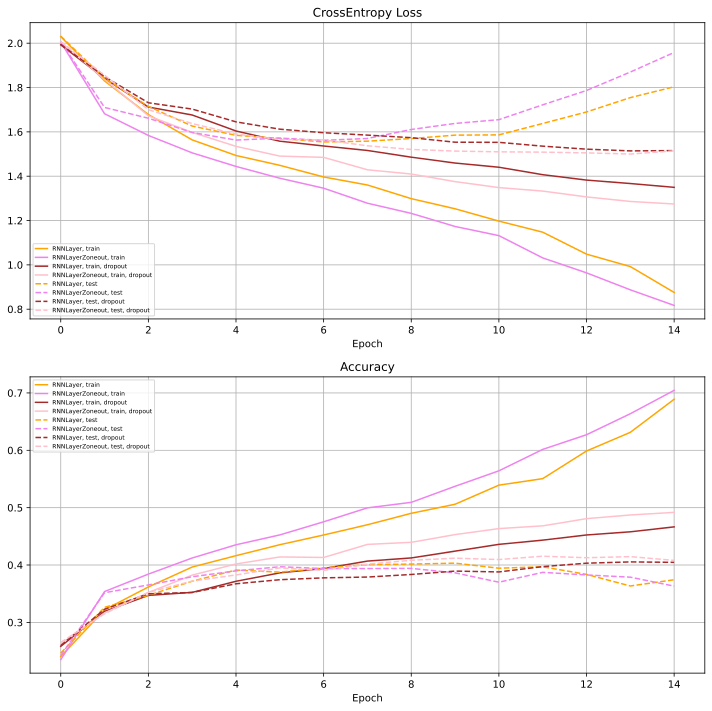

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE

axes[0].plot(train_losses_pure_1, label='RNNLayer, train', color='orange')
axes[0].plot(train_losses_pure_bonus_1, label='RNNLayerZoneout, train', color='violet')

axes[0].plot(train_losses_pure_2, label='RNNLayer, train, dropout', color='brown')
axes[0].plot(train_losses_pure_bonus_2, label='RNNLayerZoneout, train, dropout', color='pink')

axes[0].plot(test_losses_pure_1, label='RNNLayer, test', color='orange', linestyle='--')
axes[0].plot(test_losses_pure_bonus_1, label='RNNLayerZoneout, test', color='violet', linestyle='--')

axes[0].plot(test_losses_pure_2, label='RNNLayer, test, dropout', color='brown', linestyle='--')
axes[0].plot(test_losses_pure_bonus_2, label='RNNLayerZoneout, test, dropout', color='pink', linestyle='--')

axes[0].legend(fontsize=6)
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].plot(train_accuracies_pure_1, label='RNNLayer, train', color='orange')
axes[1].plot(train_accuracies_pure_bonus_1, label='RNNLayerZoneout, train', color='violet')

axes[1].plot(train_accuracies_pure_2, label='RNNLayer, train, dropout', color='brown')
axes[1].plot(train_accuracies_pure_bonus_2, label='RNNLayerZoneout, train, dropout', color='pink')

axes[1].plot(test_accuracies_pure_1, label='RNNLayer, test', color='orange', linestyle='--')
axes[1].plot(test_accuracies_pure_bonus_1, label='RNNLayerZoneout, test', color='violet', linestyle='--')

axes[1].plot(test_accuracies_pure_2, label='RNNLayer, test, dropout', color='brown', linestyle='--')
axes[1].plot(test_accuracies_pure_bonus_2, label='RNNLayerZoneout, test, dropout', color='pink', linestyle='--')

axes[1].legend(fontsize=6)
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Без использования Dropout новая модель сильнее переобучается, зато с использованием дает лучше качество (и меньше loss) и на train, и на test.  Но при этом время обучения вырастает в 1,5 раза.

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://blog.feedly.com/wp-content/uploads/2019/03/Screen-Shot-2019-03-06-at-12.08.35-PM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации — конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется. 

## `Реализация модели и цикла обучения (2 балла)`

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [41]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, vocab, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: 
            Batch of texts represented with tokens. Shape: [T, B]
        :param torch.Tensor(dtype=torch.long) tokens_lens: 
            Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.Tensor: 
            Distribution of next token for each time step. Shape: [T, B, V], V — size of vocabulary
        """
        # Make embeddings for all tokens
        # YOUR CODE HERE
        x = self.word_embeddings(tokens)
        
        # Forward pass embeddings through network
        # YOUR CODE HERE
        x = self.rnn(x)[0]
        
        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        # YOUR CODE HERE
        return self.output(x)

Реализуем функцию потерь для данной задачи. 

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`. 

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [42]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [43]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [44]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE

        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu(), enforce_sorted=False, batch_first=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu(), enforce_sorted=False, batch_first=False).data
        
        # Use super().forward(..., ...) to compute CrossEntropyLoss
        # YOUR CODE HERE
        return super().forward(packed_outputs, packed_tokens)

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [45]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first 
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu(), enforce_sorted=False, batch_first=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu(), enforce_sorted=False, batch_first=False).data
        pred = torch.argmax(packed_outputs, dim=1)
        return (pred == packed_tokens).sum()

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [46]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        # 1. Take data from batch
        # 2. Perform forward pass
        # 3. Evaluate loss
        # 4. Make optimizer step
        # YOUR CODE HERE
        # 1
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        # 2
        optimizer.zero_grad()
        pred = model(tokens, tokens_lens + 1)
        # 3
        loss = loss_fn(pred, tokens, tokens_lens + 1)
        loss.backward()
        # 4
        optimizer.step()
    
def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    
    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0
    
    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            # 2. Perform forward pass
            # 3. Evaluate loss
            # 4. Evaluate accuracy
            # YOUR CODE HERE
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            pred = model(tokens, tokens_lens + 1)
            loss = loss_fn(pred, tokens, tokens_lens + 1).item()
            n = (tokens_lens).sum().item()
            total_loss += loss * n
            total_accuracy += accuracy_fn(pred, tokens, tokens_lens + 1).item()
            total_tokens += n

            
    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        
        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    return train_losses, train_accuracies, test_losses, test_accuracies

Теперь у нас всё готово для обучения модели.

Создадим словарь с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [47]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0
# min_freq=8 is approximately equivalent to max_size=30000. 
#   You can lower min_freq in order to make model vocabulary more diverse 
# lm_vocab = torchtext.vocab.vocab(counter, specials=specials, special_first=True, min_freq=8)

In [48]:
# я сделаю lm_vocab так, как он был сделан в самом начале, потому что это добро не работает
size = 30000
lm_vocab = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:size]
lm_vocab = torchtext.vocab.vocab(OrderedDict(lm_vocab))
lm_vocab.insert_token('<pad>', 0)
lm_vocab.insert_token('<unk>', 1)
lm_vocab.insert_token('<sos>', 2)
lm_vocab.insert_token('<eos>', 3)
lm_vocab.set_default_index(lm_vocab['<unk>'])

In [49]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, lm_vocab, max_len=20, pad_sos=True, pad_eos=True)

Создадим даталоадеры для тестовой и обучающей выборок:

In [50]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=96, shuffle=False, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=96, shuffle=True, num_workers=0, 
    collate_fn=partial(collate_fn, padding_value=lm_vocab.lookup_indices(['<pad>'])[0])
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце — `<eos>` токен.

In [51]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [ 4757, 20711,    20,  ...,   886,   838,     6],
         [  592,    12,   137,  ...,  1780,   306,   140],
         ...,
         [  290,   165,     5,  ..., 19604,     5,   243],
         [    4,    21,    97,  ...,  7370,     6,    32],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 15, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20]))

Создадим модель, функцию потерь и оптимизатор: 

In [52]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, vocab=lm_vocab, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [53]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [54]:
lm_train_losses, lm_train_accuracies, lm_test_losses, lm_test_accuracies = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)

Epoch: 1/10. Loss (Train/Test): 7.658/7.777. Accuracy (Train/Test): 0.077/0.077
Epoch: 2/10. Loss (Train/Test): 7.392/7.585. Accuracy (Train/Test): 0.089/0.088
Epoch: 3/10. Loss (Train/Test): 7.190/7.483. Accuracy (Train/Test): 0.095/0.093
Epoch: 4/10. Loss (Train/Test): 6.985/7.404. Accuracy (Train/Test): 0.096/0.094
Epoch: 5/10. Loss (Train/Test): 6.831/7.373. Accuracy (Train/Test): 0.102/0.098
Epoch: 6/10. Loss (Train/Test): 6.616/7.325. Accuracy (Train/Test): 0.110/0.103
Epoch: 7/10. Loss (Train/Test): 6.440/7.308. Accuracy (Train/Test): 0.116/0.106
Epoch: 8/10. Loss (Train/Test): 6.324/7.358. Accuracy (Train/Test): 0.117/0.105
Epoch: 9/10. Loss (Train/Test): 6.126/7.340. Accuracy (Train/Test): 0.125/0.108
Epoch: 10/10. Loss (Train/Test): 5.980/7.367. Accuracy (Train/Test): 0.129/0.109


## `Реализация декодера (1 балл)`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [55]:
@torch.no_grad()
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum lenght of generated samples
    :param Optional[int] top_k: Number of tokens with the largest probability to sample from
    :return Tuple[torch.Tensor, torch.Tensor]. 
        Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = model.word_embeddings(start_tokens)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        x, (h, c) = model.rnn(embedding[time_step][None, ...], (h, c))
        all_h.append(h)
        all_c.append(c)
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = model.output(h[-1])
        
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token. 
            # YOUR CODE HERE
            next_token = torch.distributions.categorical.Categorical(logits=logits).sample()
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = torch.argmax(logits, dim=-1)
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Compute embedding for next token
        # YOUR CODE HERE
        embedding = model.word_embeddings(next_token)
        
        # Update hidden and cell states
        # YOUR CODE HERE
        x, (h, c) = model.rnn(embedding[None, ...], (h, c))
        
    return torch.stack(predicted_tokens), decoded_lens

Попробуем сгенерировать продолжения для нескольких префиксов:

In [56]:
start_tokens = torch.tensor([
    lm_model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    lm_model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'best', 'movie']),
    lm_model.vocab.lookup_indices(['<sos>', 'the', 'worst', 'movie']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [57]:
lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=5)

In [58]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> film one best documentaries seen long time time one worst thing film ever seen film ever made one thing ever
<sos> <unk> favorite movie seen years ago remember one time favorites really enjoy movie great fun movie good movie bad casting bad directing bad
<sos> <unk> best movie ever seen life movie <unk> really liked movie really good movie bad funny bad movies watch bad <eos>
<sos> <unk> worst movie ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad


Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [59]:
# YOUR CODE HERE
def top_k(k):
  print('K = ', k)
  decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
  for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

In [60]:
lst = list(range(1, 10)) + list(range(10, 30, 3))

In [61]:
for k in lst:
  top_k(k)

K =  1
<sos> movie one worst movies ever seen life even worse movie ever seen movie ever seen movie bad acting bad directing
<sos> <unk> favorite movie ever seen movie first time saw movie theater time ago remember movie theater movie remember movie <eos>
<sos> <unk> best movie ever seen life movie ever seen movie first time saw movie theater time ago remember movie <eos>
<sos> <unk> worst movie ever seen life movie ever seen movie ever seen movie theater one worst movies ever seen bad acting bad directing
K =  2
<sos> film one worst films ever seen life film ever seen film ever seen film ever seen film ever made one
<sos> <unk> favorite movie ever seen movie really enjoyed movie great movie great cast good music good movie good movie good story line <eos>
<sos> <unk> best movie ever made movie ever seen life movie ever seen movie really liked movie really bad movie bad movie bad acting
<sos> <unk> worst movie ever seen movie ever seen life even though movie bad acting bad directing ba

In [62]:
top_k(None)

K =  None
<sos> movie one worst movies ever seen life even worse movie ever seen movie ever seen movie bad acting bad directing
<sos> <unk> favorite movie ever seen movie first time saw movie theater time ago remember movie theater movie remember movie <eos>
<sos> <unk> best movie ever seen life movie ever seen movie first time saw movie theater time ago remember movie <eos>
<sos> <unk> worst movie ever seen life movie ever seen movie ever seen movie theater one worst movies ever seen bad acting bad directing


**Ответ:** Жадное декодирование (вроде) совпадает с top-1. При изменении k предложения целиком меняются и возникает ощущение, что при некотором среднем k они становятся заметно более связными. Например, при K =  7: saw movie twice first saw preview cable movie years ago ago loved movie theater came watching movie week. При большом k непонятно даже о чем предложение, например при K=28: worst movie ever seen acting worst thing ever made <unk> life like movie terrible movie making many people. Вроде отдельные словосочетания и части предложения понятны, а целиком - не очень.

## `Beam Search (2 балла)`

Рассмотрим более продвинутый алгоритм для декодирования. Реализуйте алгоритм Beam Search.

Несколько замечаний по имплементации:

1. При больших размерах `beam_size` число гипотез ($B \times \text{beam\_size}$) на очередном шаге может быть слишком большим. Поэтому может потребоваться разбить все гипотезы на отдельные батчи и делать forward-pass в несколько итераций. Используйте [`torch.split`](https://pytorch.org/docs/stable/generated/torch.split.html)
2. Для выбора лучших гипотез используйте [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html). Обратите внимание на индексы, которые возвращает эта функция (может пригодиться метод [`torch.remainder`](https://pytorch.org/docs/stable/generated/torch.remainder.html))
3. Можно отслеживать, какие элементы в батче (или какие гипотезы) закончили генерацию. Делая forward-pass только для незавершённых гипотез, можно ускорить декодинг, однако, это усложнит реализацию

In [164]:
@torch.no_grad()
def decode_beam_search(model, start_tokens, start_tokens_lens, max_generated_len=20, beam_size=5):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum length of generated samples
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor]. 
        Newly predicted tokens, probabilities for each hypotheses and lengths of generated parts
        Shape [T*, B, beam_size], [T*, beam_size], [T*, beam_size]
    """
    # !!! судя по всему, в последних двух shape опечатка: должно быть число батчей * beam_size
    
    # 1. Initialize beams and hypotheses probabilities for each element in the batch
    # 2. While all sequences do not end with <eos> and their length less than max_generated_len
    #    1. Perform forward pass and obtain probabilities for all extensions
    #    2. Compute probabilities for all hypotheses
    #    3. Select top-beam_size hypotheses for each element in the batch
    #    4. Take tokens that correspond to the chosen hypotheses
    #    5. Concat new tokens to existing prefixes

    '''
    embedding = model.word_embeddings(start_tokens)
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        x, (h, c) = model.rnn(embedding[time_step][None, ...], (h, c))
        all_h.append(h)
        all_c.append(c)
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
'''
    # embedding = model.word_embeddings(start_tokens)
    # all_h = embedding.zeros(([beam_size, model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim]), dtype=torch.long)
    # all_c = embedding.zeros(([beam_size, model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim]), dtype=torch.long)
    # print(all_h[0].size())
    '''
    embedding = []
    H = []
    C = []
    for i in range(beam_size):
      embedding = model.word_embeddings(start_tokens)
      h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
      c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
      all_h, all_c = [], []
      for time_step in range(start_tokens.shape[0]):
        x, (h, c) = model.rnn(embedding[time_step][None, ...], (h, c))
        all_h.append(h)
        all_c.append(c)
      all_h = torch.stack(all_h, dim=1)
      all_c = torch.stack(all_c, dim=1)
      h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
      c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
      embedding = [embedding] * beam_size
      H.append(h)
      C.append(c)

    all_h = H
    print('all h', len(H), H[0].size())
    all_c = C
    '''
    
    '''

    # Top-k sampling. Use only top-k most probable logits to sample next token
    indices_to_remove = logits < torch.topk(logits, beam_size)[0][..., -1, None]
    # Mask non top-k logits
    logits[indices_to_remove] = -1e10
    # Sample next_token. 
    # YOUR CODE HERE
    next_token = torch.distributions.categorical.Categorical(logits=logits).sample()
            
    predicted_tokens.append(next_token)
        
    # decoded_lens += (~is_finished_decoding)
     # is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

    # embedding = model.word_embeddings(next_token)

    # x, (h, c) = model.rnn(embedding[None, ...], (h, c))
        
    pred_tokens = torch.stack(predicted_tokens * beam_size, dim=0)

    all_h = torch.stack([h for i in range(beam_size)])
    all_c = torch.stack([c for i in range(beam_size)])
    # embedding = torch.stack([embed for i in range(beam_size)])

    predicted_tokens = []
    all_probs = []
    predicted_probs = torch.zeros((start_tokens.size(0), beam_size), dtype=torch.float)
    # Stop when all sequences in the batch are finished
    '''
    embed = model.word_embeddings(start_tokens)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embed.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embed.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        x, (h, c) = model.rnn(embed[time_step][None, ...], (h, c))
        all_h.append(h)
        all_c.append(c)
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    all_h = torch.stack([h for i in range(beam_size)])
    all_c = torch.stack([c for i in range(beam_size)])
    embedding = torch.stack([embed for i in range(beam_size)])

    predicted_tokens = []
    decoded_lens = torch.zeros((len(start_tokens_lens), beam_size), dtype=torch.long)
    is_finished_decoding = torch.zeros((len(start_tokens_lens), beam_size), dtype=torch.bool)

    logits = model.output(h[-1])
    logits[:, model.vocab['<unk>']] = -1e10
    logits = torch.log_softmax(logits, dim=-1)
    topk = torch.topk(logits, beam_size, dim=1)
    next_tokens = topk[1]
    prob = topk[0]

    ans = next_tokens[None, :, :]
    all_tokens = [next_tokens for i in range(beam_size)]
    all_probs = [prob for i in range(beam_size)]

    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
      # pred, h, c, probs = [], [], [], []
      # print('pred_tokens.size()', pred_tokens.size())
      # all_probs = torch.stack([prob for i in range(beam_size)])
      # all_tokens = torch.stack([next_tokens for i in range(beam_size)])
      for i in range(beam_size):
        if torch.all(is_finished_decoding[:, i]):
          all_tokens[i] = torch.tensor(model.vocab.lookup_indices(['<eos>'])[0])
          continue
        else:
          new_embedding = model.word_embeddings(next_tokens[:, i])
          x_new, (h_new, c_new) =  model.rnn(new_embedding[None, :, :], (all_h[i], all_c[i]))
          all_h[i] = h_new
          all_c[i] = c_new

          logits = model.output(h_new[-1])
          logits[:, model.vocab['<unk>']] = -1e10
          logits = torch.log_softmax(logits, dim=-1)
          topk = torch.topk(logits, beam_size, dim=-1)
          all_tokens[i] = topk[1]
          # print(topk[0])
          all_probs[i] += topk[0] + prob[:, i][:, None]
          # print(all_probs[i])
      
      # topk = torch.topk(torch.cat(all_probs, dim=1), beam_size, dim=-1)
      topk = torch.topk(torch.cat(all_probs, dim=1), beam_size, dim=-1)

      top_tokens = topk[1]
      prob = topk[0]
      # print(prob)

      # decoded_lens += (~is_finished_decoding)
      # is_finished_decoding |= (next_tokens == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

      prev_tokens = []
      neeext_tokens = []
      top = []
      # next_tokens = []
      # print(ans.size())
      help_all_tokens = torch.cat(all_tokens, dim=1)

      for i in range(start_tokens.size(0)):  # цикл по батчу
        top.append(torch.ones((beam_size), dtype=torch.long) * i)
      top = torch.stack(top, dim=0)
      beams = top_tokens.div(beam_size, rounding_mode='floor')
      next_tokens = help_all_tokens[top, top_tokens]
      prev_tokens = ans[:, top, beams]
      ans = torch.cat([prev_tokens, next_tokens[None, :, :]], dim=0)

      decoded_lens += (~is_finished_decoding)
      is_finished_decoding |= (next_tokens == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))
      '''

      for i in range(next_tokens.size(0)):  # цикл по батчу
        beams = next_tokens[i].div(beam_size, rounding_mode='floor')
        prev_tokens.append(ans[:, i, beams])
        neeext_tokens.append(next_tokens[i, next_tokens[i]]) # ???????
        # all_probs[i] 
      neeext_tokens = torch.cat(neeext_tokens) #[None, ...]
      prev_tokens = torch.cat(prev_tokens)
      ans = torch.cat([prev_tokens, neeext_tokens])
      '''

    return ans, all_probs, decoded_lens


    '''
          h.append(h_new)
          c.append(c_new)

          logits = model.output(h_new[-1])
          logits[:, model.vocab['<unk>']] = -1e10
          best = torch.topk(logits, beam_size)

          indices_to_remove = logits < best[0][..., -1, None]
          logits[indices_to_remove] = -1e10
          probs = torch.nn.functional.softmax(best[0])
          # print(probs.size())
          predicted_probs += torch.log(probs)

        next_token = torch.distributions.categorical.Categorical(logits=logits).sample()
        pred.append(next_token)

        decoded_lens[:, i] += (~is_finished_decoding[:, i])
        is_finished_decoding[:, i] |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))
      all_h = torch.stack(h, dim=0)
      all_c = torch.stack(c, dim=0)
      pred_tokens = torch.stack(pred, dim=0)
      predicted_tokens.append(torch.stack(pred, dim=1))
      all_probs.append(predicted_probs)
      '''
    return torch.stack(predicted_tokens, dim=0), all_probs, decoded_lens











    device = start_tokens.device
    
    # 1. Initialize beams and hypotheses probabilities for each element in the batch
    batch_size = start_tokens.shape[1]
    beams = [(start_tokens[i], torch.tensor([0.], device=device)) for i in range(batch_size)]
    beams_last = beams

    decoded_lens = torch.zeros(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    all_hypotheses = []
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        
        # 2.1 Perform forward pass and obtain probabilities for all extensions
        new_beams = []
        for beam in beams:
            prefix, p_prefix= beam
            last_token = prefix[-1].unsqueeze(0)
            logits = model(last_token, start_tokens_lens)
            probs = torch.nn.functional.softmax(logits, dim=-1).squeeze(0)
            
            # 2.2 Compute probabilities for all hypotheses
            p_all_hypotheses = p_prefix + torch.log(probs)
            
            # 2.3 Select top-beam_size hypotheses for each element in the batch
            top_k = torch.topk(p_all_hypotheses, beam_size)
            p_top_k = top_k.values
            idx_top_k = top_k.indices
            
            # 2.4 Take tokens that correspond to the chosen hypotheses
            # d = prefix.expand(beam_size, -1)
            prefixes_top_k = torch.cat([prefix.expand(beam_size, -1), idx_top_k.unsqueeze(1).expand(beam_size, -1)], dim=1)

            # 2.5 Concat new tokens to existing prefixes
            # last_extend = [(prefixes_top_k[:, i], p_top_k[i]) for i in range(beam_size)]
            new_beams.extend([(prefixes_top_k[:, i], p_top_k[i]) for i in range(beam_size)])
        beams = []
        flag = True
        # 2.6 Store all hypotheses for the current time step
        # print(len(last_extend))
        for hypothesis in new_beams[-1]:
            prefix, p_prefix = hypothesis
            last_token = prefix[-1].unsqueeze(0)
            if last_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]):
                all_hypotheses.append((prefix, p_prefix))
            else:
                beams.append(hypothesis)
                all_hypotheses.append((prefix, p_prefix))
                if flag:
                  beams_last = []
                  beams_last.append(hypothesis)
                  flag = False
                else:
                  beams_last.append(hypothesis)
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding[i] |= (last_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))
            
        
        # 2.7 If all sequences end with <eos>, stop generation
        # if last_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]):
            # break
    
    # 3. Return newly predicted tokens, probabilities for each hypotheses and lengths of generated parts
    all_hypotheses.sort(key=lambda x: x[1], reverse=True)
    best_hypotheses = all_hypotheses[:max_generated_len]
    best_hypotheses_tokens = torch.stack([hypothesis[0] for hypothesis in best_hypotheses], dim=1)
    best_hypotheses_probs = torch.tensor([hypothesis[1] for hypothesis in best_hypotheses], device=device)
    best_hypotheses_lens = torch.sum(best_hypotheses_tokens != model.vocab.lookup_indices(['<pad>'])[0], dim=0)
    
    return best_hypotheses_tokens, best_hypotheses_probs, best_hypotheses_lens



    '''
    embedding = model.word_embeddings(start_tokens)
    
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        x, (h, c) = model.rnn(embedding[time_step][None, ...], (h, c))
        all_h.append(h)
        all_c.append(c)
    
    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    
    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = model.output(h[-1])

        # Top-k sampling. Use only top-k most probable logits to sample next token
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        # Mask non top-k logits
        logits[indices_to_remove] = -1e10
        # Sample next_token. 
        # YOUR CODE HERE
        next_token = torch.distributions.categorical.Categorical(logits=logits).sample()
            
        predicted_tokens.append(next_token)
        
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))

        # Compute embedding for next token
        # YOUR CODE HERE
        embedding = model.word_embeddings(next_token)
        
        # Update hidden and cell states
        # YOUR CODE HERE
        x, (h, c) = model.rnn(embedding[None, ...], (h, c))
        
    return torch.stack(predicted_tokens), decoded_lens
    '''

In [165]:
decoded_tokens, decoded_probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, beam_size=5)
'''
for text_idx in range(start_tokens.shape[1]):
  print(decoded_lens[text_idx])
  print(text_idx)
  decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
  tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
  words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
  print(' '.join(words))
  '''

"\nfor text_idx in range(start_tokens.shape[1]):\n  print(decoded_lens[text_idx])\n  print(text_idx)\n  decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]\n  tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()\n  words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]\n  print(' '.join(words))\n  "

In [127]:
decoded_probs

[tensor([[-1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17],
         [-1.2157e+17, -1.2157e+17, -1.2157e+17, -1.2157e+17, -1.2157e+17],
         [-9.8608e+16, -9.8608e+16, -9.8608e+16, -9.8608e+16, -9.8608e+16],
         [-9.6565e+16, -9.6565e+16, -9.6565e+16, -9.6565e+16, -9.6565e+16]]),
 tensor([[-1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17],
         [-1.2157e+17, -1.2157e+17, -1.2157e+17, -1.2157e+17, -1.2157e+17],
         [-9.8608e+16, -9.8608e+16, -9.8608e+16, -9.8608e+16, -9.8608e+16],
         [-9.6565e+16, -9.6565e+16, -9.6565e+16, -9.6565e+16, -9.6565e+16]]),
 tensor([[-1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17],
         [-1.2157e+17, -1.2157e+17, -1.2157e+17, -1.2157e+17, -1.2157e+17],
         [-9.8608e+16, -9.8608e+16, -9.8608e+16, -9.8608e+16, -9.8608e+16],
         [-9.6565e+16, -9.6565e+16, -9.6565e+16, -9.6565e+16, -9.6565e+16]]),
 tensor([[-1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17, -1.3407e+17],
      

In [163]:
for i in range(decoded_tokens.size(1)):
  print('batch', i)
  for j in range(decoded_tokens.size(2)):
    tokens_codes = decoded_tokens[:decoded_lens[i, j], i, j]
    tokens = start_tokens[:start_tokens_lens[i], i].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    # print(decoded_probs[i, j].item())
    print(' '.join(words))

batch 0
<sos> ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
<sos> ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
<sos> ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
<sos> ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
<sos> ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
batch 1
<sos> <unk> favorite movie ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
<sos> <unk> favorite movie ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
<sos> <unk> favorite movie ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
<

In [166]:
decoded_tokens, decoded_probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, beam_size=1)

In [167]:
for i in range(decoded_tokens.size(1)):
  print('batch', i)
  for j in range(decoded_tokens.size(2)):
    tokens_codes = decoded_tokens[:decoded_lens[i, j], i, j]
    tokens = start_tokens[:start_tokens_lens[i], i].tolist() + decoded_text_tokens.tolist()
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    # print(decoded_probs[i, j].item())
    print(' '.join(words))

batch 0
<sos> ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
batch 1
<sos> <unk> favorite movie ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
batch 2
<sos> <unk> best movie ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad
batch 3
<sos> <unk> worst movie ever seen movie ever seen life movie even though one funniest movies ever seen movie even though bad bad bad


было два варианта реализации. один (нравится мне больше) не закомментирован и возвращает то, что вы можете видеть выше. второй закомментаирован и дает то, что ниже

In [ ]:
decoded_tokens, decoded_probs, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, beam_size=1)

In [93]:
for i in range(decoded_tokens.size(1)):
  print("batch", i)
  for j in range(decoded_tokens.size(2)):
    tokens = start_tokens[:4, i].tolist()
    for k in range(decoded_tokens.size(0)):
      tokens.append(decoded_tokens[k][i][j])
    # tokens = decoded_tokens[:][j][i]
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

batch 0
<sos> <pad> <pad> <pad> great example movie great cast great cast great cast great story line great cast great job great cast great job
batch 1
<sos> <unk> favorite movie seen movie made movie made movie great cast great cast great cast great cast great cast great cast great <eos>
batch 2
<sos> <unk> best movie seen movie ever seen movie seen long time see movie great cast great cast great cast great cast great <eos>
batch 3
<sos> <unk> worst movie seen life movie bad acting bad plot bad acting bad special effects bad special effects bad acting bad <eos> <eos>


In [ ]:
decoded_tokens, _, decoded_lens = decode_beam_search(lm_model, start_tokens, start_tokens_lens, beam_size=5)

In [95]:
for i in range(decoded_tokens.size(1)):
  print("batch", i)
  for j in range(decoded_tokens.size(2)):
    tokens = start_tokens[:4, i].tolist()
    for k in range(decoded_tokens.size(0)):
      tokens.append(decoded_tokens[k][i][j])
    # tokens = decoded_tokens[:][j][i]
    words = np.array(lm_model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

batch 0
<sos> <pad> <pad> <pad> awesome cast well done movie great acting good story line movie great story lines great job great story good job
<sos> <pad> <pad> <pad> bad bad good bad acting bad script poor acting bad acting bad special effects bad plot lines bad acting bad
<sos> <pad> <pad> <pad> awesome acting actresses good acting excellent plot interesting characters great actors great cast good job also good story lines good
<sos> <pad> <pad> <pad> starts good acting pretty good acting great plot great acting good story good acting good cast bad acting bad plot
<sos> <pad> <pad> <pad> awesome acting good story line great movie good actors great story also well written story line movie really good movie
batch 1
<sos> <unk> favorite movie made saw movie times saw one best movies time seen first time one really liked movie first saw trailer <eos>
<sos> <unk> favorite movie made movie made one best movies ever seen saw movie times one worst films ever seen <eos> bad <eos> <eos>
<sos

Попробуйте выполнить декодинг для разных `beam_size`. Убедитесь, что при `beam_search=1` семплирование совпадает с top-1 (greedy decoding) подходом. 

Сравните результаты Beam Search с top-k семплированием и жадным декодированием. Опишите ваши наблюдения.

p.s. я активно пыталась это сделать с субботы)

In [ ]:
# YOUR CODE HERE

## `Бонус. Существенное улучшение качества (до 6 баллов)`

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов **(+0.25)**
2. Dropout входов и выходов RNN **(+0.25)**
3. Регуляризация активаций (AR/TAR) **(+1.0)**
4. NT-ASGD **(+1.5)**
5. Tied веса эмбеддингов и софтмакса **(+1.0)**
6. Attention **(+2.0)**

**Полные баллы ставятся только при наличии качественного и количественного сравнения с бейзлайном.**

**Для эксперимента с Attention необходимо изобразить Attention Maps для нескольких примеров.**